In [1]:
import pandas as pd
import sklearn 
import numpy as np
import matplotlib.pyplot as plt
import json
import keras
from keras import models 
from keras import layers
from keras import regularizers
from keras import utils
from keras.utils import np_utils




from numpy.random import seed
seed(1)

%matplotlib inline


/Users/kate/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print('DOTSCIENCE_INPUTS=["titanic/train.csv", "titanic/test.csv"]')

# TODO: set up keras callback to save .h5
print('DOTSCIENCE_OUTPUTS=["model"]')
print('DOTSCIENCE_LABELS={"model_type": "DNN"}')

DOTSCIENCE_INPUTS=["titanic/train.csv", "titanic/test.csv"]
DOTSCIENCE_OUTPUTS=["model"]
DOTSCIENCE_LABELS={"model_type": "DNN"}


In [3]:
df = pd.read_csv("titanic/train.csv")

In [4]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

In [5]:
df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
df.drop(columns='Sex', inplace=True)

In [6]:
# set Embarked_ternary to 1 for C, 2 for Q, 3 for S
df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))

In [7]:
count_nan = len(df['Cabin']) - df['Cabin'].count()
print(count_nan)

687


OK, so most of the Cabin values are NaN, so we can probably drop this column.

In [8]:
df.drop(columns='Cabin', inplace=True)

Slightly more likely to survive if younger:

In [9]:
df.groupby(['Survived']).Age.mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

Higher average fare amongst survivors:

In [10]:

df.groupby(['Survived']).Fare.mean()

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

How does survival vary with embarkation point?

In [11]:
print("number embarked at Cherbourg", len(df.loc[df['Embarked_ternary'] == 1]))
print("average survival status", df.loc[df['Embarked_ternary'] == 1].Survived.mean())
print("\n")
print("number embarked at Queenstown", len(df.loc[df['Embarked_ternary'] == 2]))
print("average survival status", df.loc[df['Embarked_ternary'] == 2].Survived.mean())
print("\n")
print("number embarked at Southampton", len(df.loc[df['Embarked_ternary'] == 3]))
print("average survival status", df.loc[df['Embarked_ternary'] == 3].Survived.mean())

number embarked at Cherbourg 168
average survival status 0.5535714285714286


number embarked at Queenstown 77
average survival status 0.38961038961038963


number embarked at Southampton 646
average survival status 0.33900928792569657


OK, so there is some evidence that embarking at Cherbourg is correlated with survival. So let's turn embarkation_ternary into a binary condition: emarbarked_at_cherbourg

In [12]:
df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)
df.drop(columns="Embarked_ternary", inplace=True)

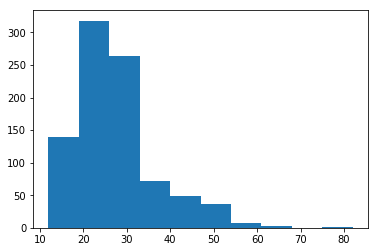

In [13]:
# how do the name lengths vary? And are they correlated with survival?

names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
name_lens = [name_len[1] for name_len in names_lens]
plt.hist(name_lens)
plt.show()

In [14]:
# add an int value for name length
df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]

In [15]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binary,Embarked_at_cherbourg,Name_len
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,-0.001205,-0.012986
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,0.168240,0.332350
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,-0.243292,-0.220001
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.036261,0.034612
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.059528,0.165019
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.011069,0.252282
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,0.269335,0.155832
Sex_binary,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,0.082853,0.448759
Embarked_at_cherbourg,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,1.000000,0.027481
Name_len,-0.012986,0.332350,-0.220001,0.034612,0.165019,0.252282,0.155832,0.448759,0.027481,1.000000


woah, having a long name is almost as highly correlated with survival as passanger class!

In [16]:
# todo: engineer ticket class
# for now, we'll just drop it

df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)

In [17]:
df.dtypes

Survived                   int64
Pclass                     int64
Age                      float64
SibSp                      int64
Parch                      int64
Fare                     float64
Sex_binary                 int64
Embarked_at_cherbourg      int64
Name_len                   int64
dtype: object

In [18]:
df.isnull().any()

Survived                 False
Pclass                   False
Age                       True
SibSp                    False
Parch                    False
Fare                     False
Sex_binary               False
Embarked_at_cherbourg    False
Name_len                 False
dtype: bool

We have some null ages. Let's see how many.

In [19]:
len(df.loc[df.Age.isnull()])

177

In [20]:
# naively fill nulls for now. Better to predict missing ages on basis of available data.
df.fillna(df.mean(), inplace=True)

In [21]:
# get Survived/not Survived as  categorical value, to make compatible  with network and to use categorical_crossentropy as loss metric.
(train_passengers, train_labels) = (df.drop('Survived', axis=1), keras.utils.to_categorical(df['Survived'], num_classes=None, dtype='float32'))

In [22]:
train_labels.shape

(891, 2)

In [23]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train_passengers)
scaler.transform(train_passengers, copy=False)

array([[ 0.82737724, -0.5924806 ,  0.43279337, ..., -0.73769513,
        -0.48204268, -0.42745127],
       [-1.56610693,  0.63878901,  0.43279337, ...,  1.35557354,
         2.0745051 ,  2.59096206],
       [ 0.82737724, -0.2846632 , -0.4745452 , ...,  1.35557354,
        -0.48204268, -0.53525175],
       ...,
       [ 0.82737724,  0.        ,  0.43279337, ...,  1.35557354,
        -0.48204268,  1.40515682],
       [-1.56610693, -0.2846632 , -0.4745452 , ..., -0.73769513,
         2.0745051 , -0.64305222],
       [ 0.82737724,  0.17706291, -0.4745452 , ..., -0.73769513,
        -0.48204268, -0.85865317]])

In [24]:
# train_passengers is df
train_passengers[train_passengers.columns] = scaler.fit_transform(train_passengers[train_passengers.columns])

In [25]:
# make a function with preceding data-wrangling steps, so that we can perform the same operations on the test set
def wrangle(df):
    """
    takes a df with same format as training set.
    returns df in same format as modified training set
    """
    df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
    df.drop(columns='Sex', inplace=True)
    df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))
    df.drop(columns='Cabin', inplace=True)
    df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)
    df.drop(columns="Embarked_ternary", inplace=True)
    names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
    name_lens = [name_len[1] for name_len in names_lens]
    df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]    
    df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)
    
    # naively fill in nulls for now
    df.fillna(df.mean(), inplace=True)
    return df

In [26]:
# load and transform test data
df_test = pd.read_csv("titanic/test.csv")
df_test = wrangle(df_test)

In [27]:
test_passengers = df_test
test_passengers[test_passengers.columns] = scaler.fit_transform(test_passengers[test_passengers.columns])

In [28]:
train_passengers.shape

(891, 8)

In [29]:
train_labels.shape

(891, 2)

In [32]:
from keras.layers import Dense, Activation, Dropout

network = models.Sequential()
network.add(layers.Dense(input_dim=train_passengers.shape[1], units=128,
                 kernel_initializer='normal', bias_initializer='zeros'))
network.add(Activation('relu'))

for i in range(0, 15):
    network.add(layers.Dense(units=128, kernel_initializer='normal',
                     bias_initializer='zeros'))
    network.add(Activation('relu'))
    network.add(Dropout(.40))

network.add(layers.Dense(units=2))
network.add(Activation('softmax'))

network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# TODO: record loss history: https://keras.io/callbacks/#example-recording-loss-history
# from keras.callbacks import ModelCheckpoint
# checkpointer = keras.callbacks.ModelCheckpoint(filepath="weights.h5", monitor='categorical_crossentropy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

network.fit(train_passengers, train_labels, epochs=700, verbose=2, validation_split=0.1)

#get the highest validation accuracy of the training epochs
acc = np.amax(network.history.history['acc'])


print('Best validation acc of epoch:', acc)
print('DOTSCIENCE_PARAMETERS=' + json.dumps({"regulariser": "none", "epocs": 700, "batch_size": "default", "optimizer": "adam"}))
print('DOTSCIENCE_SUMMARY=' + json.dumps({"accuracy": acc}))

Train on 801 samples, validate on 90 samples
Epoch 1/700
 - 1s - loss: 0.6797 - acc: 0.6092 - val_loss: 0.6636 - val_acc: 0.6222
Epoch 2/700
 - 0s - loss: 0.6705 - acc: 0.6155 - val_loss: 0.6639 - val_acc: 0.6222
Epoch 3/700
 - 0s - loss: 0.6499 - acc: 0.6155 - val_loss: 0.5722 - val_acc: 0.6222
Epoch 4/700
 - 0s - loss: 0.6154 - acc: 0.6155 - val_loss: 0.5955 - val_acc: 0.6222
Epoch 5/700
 - 0s - loss: 0.5908 - acc: 0.6342 - val_loss: 0.5312 - val_acc: 0.8111
Epoch 6/700
 - 0s - loss: 0.5566 - acc: 0.8027 - val_loss: 0.5552 - val_acc: 0.8333
Epoch 7/700
 - 0s - loss: 0.5611 - acc: 0.7903 - val_loss: 0.4691 - val_acc: 0.8222
Epoch 8/700
 - 0s - loss: 0.5165 - acc: 0.8015 - val_loss: 0.4576 - val_acc: 0.8111
Epoch 9/700
 - 0s - loss: 0.4982 - acc: 0.8127 - val_loss: 0.5320 - val_acc: 0.8222
Epoch 10/700
 - 0s - loss: 0.5043 - acc: 0.8015 - val_loss: 0.4871 - val_acc: 0.8222
Epoch 11/700
 - 0s - loss: 0.5096 - acc: 0.7978 - val_loss: 0.4514 - val_acc: 0.8222
Epoch 12/700
 - 0s - loss: 0.

Epoch 97/700
 - 0s - loss: 0.4476 - acc: 0.8027 - val_loss: 0.3613 - val_acc: 0.8222
Epoch 98/700
 - 0s - loss: 0.4388 - acc: 0.8265 - val_loss: 0.3808 - val_acc: 0.8222
Epoch 99/700
 - 0s - loss: 0.3972 - acc: 0.8414 - val_loss: 0.3768 - val_acc: 0.8444
Epoch 100/700
 - 0s - loss: 0.4017 - acc: 0.8414 - val_loss: 0.4039 - val_acc: 0.8333
Epoch 101/700
 - 0s - loss: 0.3827 - acc: 0.8402 - val_loss: 0.3925 - val_acc: 0.8444
Epoch 102/700
 - 0s - loss: 0.3817 - acc: 0.8464 - val_loss: 0.3649 - val_acc: 0.8444
Epoch 103/700
 - 0s - loss: 0.3914 - acc: 0.8477 - val_loss: 0.3749 - val_acc: 0.8222
Epoch 104/700
 - 0s - loss: 0.3727 - acc: 0.8489 - val_loss: 0.4746 - val_acc: 0.8111
Epoch 105/700
 - 0s - loss: 0.4005 - acc: 0.8502 - val_loss: 0.3789 - val_acc: 0.8222
Epoch 106/700
 - 0s - loss: 0.3840 - acc: 0.8539 - val_loss: 0.3761 - val_acc: 0.8444
Epoch 107/700
 - 0s - loss: 0.3763 - acc: 0.8577 - val_loss: 0.4115 - val_acc: 0.8444
Epoch 108/700
 - 0s - loss: 0.3810 - acc: 0.8552 - val_lo

Epoch 193/700
 - 0s - loss: 0.3644 - acc: 0.8589 - val_loss: 0.3690 - val_acc: 0.8333
Epoch 194/700
 - 0s - loss: 0.3964 - acc: 0.8402 - val_loss: 0.3749 - val_acc: 0.8222
Epoch 195/700
 - 0s - loss: 0.3746 - acc: 0.8489 - val_loss: 0.3784 - val_acc: 0.8333
Epoch 196/700
 - 0s - loss: 0.3490 - acc: 0.8589 - val_loss: 0.5041 - val_acc: 0.8444
Epoch 197/700
 - 0s - loss: 0.3543 - acc: 0.8702 - val_loss: 0.4301 - val_acc: 0.8333
Epoch 198/700
 - 0s - loss: 0.3419 - acc: 0.8639 - val_loss: 0.5443 - val_acc: 0.8333
Epoch 199/700
 - 0s - loss: 0.3650 - acc: 0.8564 - val_loss: 0.6520 - val_acc: 0.8444
Epoch 200/700
 - 0s - loss: 0.3640 - acc: 0.8664 - val_loss: 0.6466 - val_acc: 0.8222
Epoch 201/700
 - 0s - loss: 0.3475 - acc: 0.8577 - val_loss: 0.6470 - val_acc: 0.8333
Epoch 202/700
 - 0s - loss: 0.3514 - acc: 0.8627 - val_loss: 0.6475 - val_acc: 0.8444
Epoch 203/700
 - 0s - loss: 0.3731 - acc: 0.8614 - val_loss: 0.5360 - val_acc: 0.8222
Epoch 204/700
 - 0s - loss: 0.3735 - acc: 0.8552 - val

Epoch 289/700
 - 0s - loss: 0.3362 - acc: 0.8652 - val_loss: 0.5814 - val_acc: 0.8444
Epoch 290/700
 - 0s - loss: 0.3537 - acc: 0.8527 - val_loss: 0.5372 - val_acc: 0.8333
Epoch 291/700
 - 0s - loss: 0.3345 - acc: 0.8564 - val_loss: 0.5550 - val_acc: 0.8333
Epoch 292/700
 - 0s - loss: 0.3403 - acc: 0.8639 - val_loss: 0.5612 - val_acc: 0.8444
Epoch 293/700
 - 0s - loss: 0.3312 - acc: 0.8739 - val_loss: 0.3635 - val_acc: 0.8222
Epoch 294/700
 - 0s - loss: 0.3447 - acc: 0.8639 - val_loss: 0.3680 - val_acc: 0.8222
Epoch 295/700
 - 0s - loss: 0.3267 - acc: 0.8677 - val_loss: 0.4166 - val_acc: 0.8333
Epoch 296/700
 - 0s - loss: 0.3725 - acc: 0.8502 - val_loss: 0.5504 - val_acc: 0.8556
Epoch 297/700
 - 0s - loss: 0.3462 - acc: 0.8689 - val_loss: 0.5339 - val_acc: 0.8556
Epoch 298/700
 - 0s - loss: 0.3181 - acc: 0.8677 - val_loss: 0.5045 - val_acc: 0.8333
Epoch 299/700
 - 0s - loss: 0.3339 - acc: 0.8789 - val_loss: 0.4965 - val_acc: 0.8333
Epoch 300/700
 - 0s - loss: 0.3134 - acc: 0.8689 - val

Epoch 385/700
 - 0s - loss: 0.3341 - acc: 0.8727 - val_loss: 0.4922 - val_acc: 0.8444
Epoch 386/700
 - 0s - loss: 0.3378 - acc: 0.8689 - val_loss: 0.5372 - val_acc: 0.8222
Epoch 387/700
 - 0s - loss: 0.3602 - acc: 0.8527 - val_loss: 0.5350 - val_acc: 0.8333
Epoch 388/700
 - 0s - loss: 0.3635 - acc: 0.8627 - val_loss: 0.5115 - val_acc: 0.8222
Epoch 389/700
 - 0s - loss: 0.3231 - acc: 0.8727 - val_loss: 0.4242 - val_acc: 0.8111
Epoch 390/700
 - 0s - loss: 0.3096 - acc: 0.8639 - val_loss: 0.4996 - val_acc: 0.8333
Epoch 391/700
 - 0s - loss: 0.3662 - acc: 0.8639 - val_loss: 0.4978 - val_acc: 0.8444
Epoch 392/700
 - 0s - loss: 0.3105 - acc: 0.8727 - val_loss: 0.4887 - val_acc: 0.8444
Epoch 393/700
 - 0s - loss: 0.3086 - acc: 0.8602 - val_loss: 0.4989 - val_acc: 0.8111
Epoch 394/700
 - 0s - loss: 0.3409 - acc: 0.8427 - val_loss: 0.4657 - val_acc: 0.8222
Epoch 395/700
 - 0s - loss: 0.3317 - acc: 0.8477 - val_loss: 0.4796 - val_acc: 0.8556
Epoch 396/700
 - 0s - loss: 0.3582 - acc: 0.8539 - val

Epoch 481/700
 - 0s - loss: 0.3371 - acc: 0.8664 - val_loss: 0.5500 - val_acc: 0.7889
Epoch 482/700
 - 0s - loss: 0.3248 - acc: 0.8502 - val_loss: 0.6170 - val_acc: 0.8000
Epoch 483/700
 - 0s - loss: 0.3346 - acc: 0.8652 - val_loss: 0.6867 - val_acc: 0.8000
Epoch 484/700
 - 0s - loss: 0.3072 - acc: 0.8677 - val_loss: 0.6925 - val_acc: 0.8000
Epoch 485/700
 - 0s - loss: 0.3087 - acc: 0.8689 - val_loss: 0.6958 - val_acc: 0.7889
Epoch 486/700
 - 0s - loss: 0.2861 - acc: 0.8714 - val_loss: 0.6882 - val_acc: 0.8000
Epoch 487/700
 - 0s - loss: 0.2914 - acc: 0.8752 - val_loss: 0.6845 - val_acc: 0.8111
Epoch 488/700
 - 0s - loss: 0.3142 - acc: 0.8702 - val_loss: 0.6661 - val_acc: 0.8111
Epoch 489/700
 - 0s - loss: 0.3579 - acc: 0.8664 - val_loss: 0.5409 - val_acc: 0.8222
Epoch 490/700
 - 0s - loss: 0.3432 - acc: 0.8589 - val_loss: 0.6225 - val_acc: 0.8222
Epoch 491/700
 - 0s - loss: 0.3236 - acc: 0.8639 - val_loss: 0.6834 - val_acc: 0.8333
Epoch 492/700
 - 0s - loss: 0.3112 - acc: 0.8702 - val

Epoch 577/700
 - 0s - loss: 0.3056 - acc: 0.8727 - val_loss: 0.5950 - val_acc: 0.8444
Epoch 578/700
 - 0s - loss: 0.2893 - acc: 0.8839 - val_loss: 0.6704 - val_acc: 0.8444
Epoch 579/700
 - 0s - loss: 0.2854 - acc: 0.8789 - val_loss: 0.6667 - val_acc: 0.8333
Epoch 580/700
 - 0s - loss: 0.2884 - acc: 0.8727 - val_loss: 0.6611 - val_acc: 0.8333
Epoch 581/700
 - 0s - loss: 0.2821 - acc: 0.8739 - val_loss: 0.6615 - val_acc: 0.8333
Epoch 582/700
 - 0s - loss: 0.3056 - acc: 0.8727 - val_loss: 0.6620 - val_acc: 0.8444
Epoch 583/700
 - 0s - loss: 0.3016 - acc: 0.8801 - val_loss: 0.6559 - val_acc: 0.8333
Epoch 584/700
 - 0s - loss: 0.2839 - acc: 0.8826 - val_loss: 0.6710 - val_acc: 0.8222
Epoch 585/700
 - 0s - loss: 0.2906 - acc: 0.8851 - val_loss: 0.6643 - val_acc: 0.8333
Epoch 586/700
 - 0s - loss: 0.2975 - acc: 0.8689 - val_loss: 0.5424 - val_acc: 0.8333
Epoch 587/700
 - 0s - loss: 0.2892 - acc: 0.8739 - val_loss: 0.6599 - val_acc: 0.8333
Epoch 588/700
 - 0s - loss: 0.2828 - acc: 0.8764 - val

Epoch 673/700
 - 0s - loss: 0.2909 - acc: 0.8851 - val_loss: 0.6521 - val_acc: 0.8333
Epoch 674/700
 - 0s - loss: 0.3043 - acc: 0.8801 - val_loss: 0.6554 - val_acc: 0.8444
Epoch 675/700
 - 0s - loss: 0.2887 - acc: 0.8752 - val_loss: 0.6714 - val_acc: 0.8333
Epoch 676/700
 - 0s - loss: 0.2782 - acc: 0.8814 - val_loss: 0.6710 - val_acc: 0.8111
Epoch 677/700
 - 0s - loss: 0.2730 - acc: 0.8851 - val_loss: 0.6657 - val_acc: 0.8222
Epoch 678/700
 - 0s - loss: 0.2737 - acc: 0.8839 - val_loss: 0.6602 - val_acc: 0.8222
Epoch 679/700
 - 0s - loss: 0.2922 - acc: 0.8764 - val_loss: 0.5894 - val_acc: 0.8222
Epoch 680/700
 - 0s - loss: 0.3134 - acc: 0.8777 - val_loss: 0.6637 - val_acc: 0.8222
Epoch 681/700
 - 0s - loss: 0.2629 - acc: 0.8777 - val_loss: 0.6802 - val_acc: 0.8222
Epoch 682/700
 - 0s - loss: 0.2654 - acc: 0.8876 - val_loss: 0.6578 - val_acc: 0.8333
Epoch 683/700
 - 0s - loss: 0.2598 - acc: 0.8901 - val_loss: 0.6621 - val_acc: 0.8333
Epoch 684/700
 - 0s - loss: 0.3566 - acc: 0.8427 - val

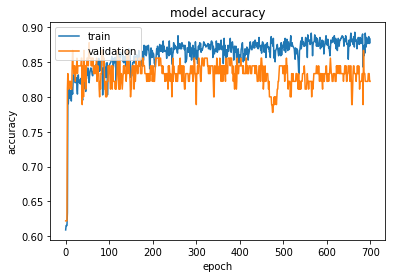

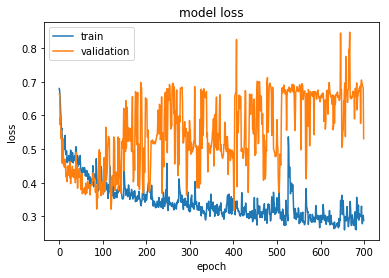

In [36]:
plt.plot(network.history.history['acc'])
plt.plot(network.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(network.history.history['loss'])
plt.plot(network.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# looks like overfitting -- add more regularisation

In [35]:
results = network.predict(test_passengers)

In [ ]:
results.shape

In [ ]:
survived = []
for result in results:
    survived.append(result[1])


plt.scatter(survived, range(len(survived)))
plt.show()

In [ ]:
# we need binary survival prediction, not a probability
binary_results = network.predict_classes(test_passengers)

In [ ]:
binary_results

In [ ]:
# get unwrangled version of test set with the passenger IDs
df_test = pd.read_csv("titanic/test.csv") 

In [ ]:
# add column for binary survival status
df_test['Survived'] = binary_results


In [ ]:
# write out results
df_test.drop(columns=['Pclass', 'Embarked', 'Name', 'Ticket', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare', 'Embarked'], inplace=True)
df_test.to_csv("titanic/predictions.csv", columns = ['PassengerId', 'Survived'], index=False)    
df_test.reset_index(drop=True, inplace=True)
